In [86]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline

In [67]:
## load in the preprocessed data and the sale prices for training data
data = pd.read_csv('Master_DF.csv')
data.set_index('Id', inplace=True)

In [68]:
# import raw training data and get log of prices
train_raw = pd.read_csv('train.csv')
train_raw.set_index('Id', inplace=True)
logprices = np.log10(train_raw.SalePrice)

In [69]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
columns = list(data.columns)

/Users/bhalbur/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bhalbur/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [70]:
scaled = pd.DataFrame(data_scaled, columns=columns)
scaled.index +=1
train = scaled.loc[1:1460,]
test = scaled.loc[1461:2919,]

In [71]:
outliers = list(train_raw[(train_raw['GrLivArea']>4000) & (train_raw['SalePrice']<300000)].index)
outliers

[524, 1299]

In [72]:
##Drop some of the correlated and categorical variables
dropcols = ['MSSubClass','MasVnrArea','TotalBsmtSF','LowQualFinSF','GrLivArea','TotRmsAbvGrd']
droprows = outliers
trim = scaled.drop(columns=dropcols)
trim = trim.drop(droprows)
trimprices = logprices.drop(droprows)

In [73]:
train = trim.loc[1:1460,]
test = trim.loc[1461:2919,]
y = trimprices

R squared: 0.9518799818959887
Root Mean Squared Error: 0.038067041307398145


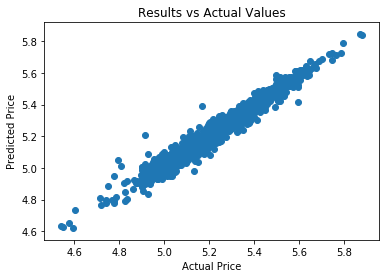

In [87]:
boost = GradientBoostingRegressor()
boost.fit(train, trimprices, sample_weight=None ,monitor=None)
yhat_boost = boost.predict(train)
plt.scatter(y, yhat_boost)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
print("R squared:",boost.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat_boost))
print("Root Mean Squared Error:",RMSE)

/Users/bhalbur/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


R squared: 0.8999275733515903
Root Mean Squared Error: 0.054896347250262933


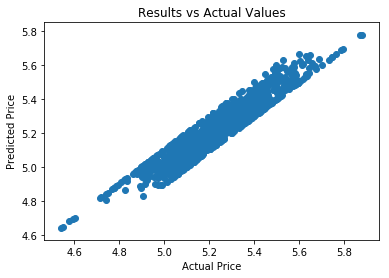

In [88]:
svr = SVR()
svr.fit(train, trimprices)
yhat_svr = svr.predict(train)
plt.scatter(y, yhat_svr)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
print("R squared:",svr.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat_svr))
print("Root Mean Squared Error:",RMSE)

R squared: 0.9182717954027287
Root Mean Squared Error: 0.04961034092735686


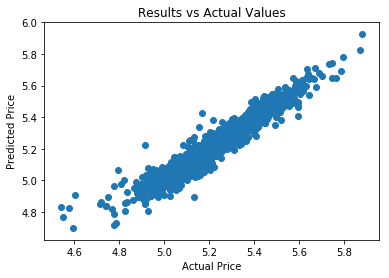

In [89]:
linreg = LinearRegression()
linreg.fit(train, trimprices)
yhat_linreg = linreg.predict(train)
plt.scatter(y, yhat_linreg)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
print("R squared:",linreg.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat_linreg))
print("Root Mean Squared Error:",RMSE)

Root Mean Squared Error: 0.041931129468763005


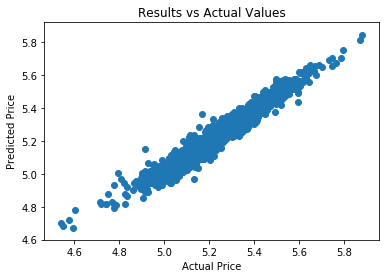

In [90]:
yhat_test_combined = (yhat_linreg + yhat_svr + yhat_boost)/3
plt.scatter(y, yhat_test_combined)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
RMSE = math.sqrt(mean_squared_error(y, yhat_test_combined))
print("Root Mean Squared Error:",RMSE)

In [91]:
yhat_sub_boost = boost.predict(test)
yhat_sub_svr = svr.predict(test)
yhat_sub_linreg = linreg.predict(test)

In [92]:
submit_yhat = (yhat_sub_boost + yhat_sub_svr + yhat_sub_linreg)/3

## Export to .csv for uploading

In [93]:
submission = pd.DataFrame({'Id':test.index, 'SalePrice': np.power(10, submit_yhat)})
submission.set_index('Id', inplace=True)
print(submission.head())
timestamp = datetime.now().strftime('%m-%d-%H-%M-%S')

      SalePrice
Id             
1461 119,273.77
1462 159,898.21
1463 175,770.03
1464 186,723.33
1465 193,628.58


In [94]:
submission.to_csv(f'submission_files/Sub{timestamp}.csv')